## TESTING
* Comparing approximate nearest neighbor results with nearest neighbors from exact similarity.
* 3 different approaches for ANN.
* 3 different approaches for comparison of nearest neighbor lists.

In [23]:
import json
from flatten_json import flatten
import pandas as pd
import numpy as np
import Levenshtein

def string_similarity(A, B):

    #calculate the edit distance
    dist = Levenshtein.distance(A, B)
    if dist == 0:
        return 1
    else:
        return 1/dist

def partial_jaccard_similarity(A, B, range=200):

    pay_off = 0.1
    length = len(A) + len(B)
    sim = 0.0

    if len(A) == 0:
        if A == B:
            sim += 1
        else: 
            sim += pay_off
    else:
        for key, value in A.items():
            if key in B.keys():
                length -= 1
                b = B[key]
                if isinstance(value, bool):
                    #print("1*")
                    if value == b:
                        sim += 1
                    else: 
                        sim += pay_off
                elif isinstance(value, int):
                    #print("2*")
                    if (isinstance(b, int) or isinstance(b, float)):
                        #more advanced similarity calculation possible, difference of values if schema has max min limits
                        #range value taken as an argument, default=200
                        value_diff = abs(value - b)
                        if value_diff > range:
                            value_diff = range
                            #print("WARNING!!! Difference in integer values exceeds given range. Value diff: ", abs(value-b), " Range: ", range)
                        sim += (range - value_diff)/range
                        #print("value_sim ", (range - value_diff)/range, " ::: ", value, b)
                    else:
                        pass
                        #print("WARNING!!! Data types for the matching keys must be the same!", type(value), type(b))
                elif isinstance(value, float):
                    #print("3*")
                    if (isinstance(b, float) or isinstance(b, int)):
                        #more advanced similarity calculation possible, difference of values if schema has max min limits
                        #range value taken as an argument, default=200
                        value_diff = abs(value - b)
                        if value_diff > range:
                            value_diff = range
                            #print("WARNING!!! Difference in float values exceeds given range. Value diff: ", abs(value-b), " Range: ", range)
                        sim += (range - value_diff)/range
                        #print("value_sim ", (range - value_diff)/range, " ::: ", value, b)
                    else:
                        pass
                        #print("WARNING!!! Data types for the matching keys must be the same!", type(value), type(b))
                elif isinstance(value, str):
                    #print("4*")
                    #str comparison
                    if isinstance(b, str):
                        sim += string_similarity(value, b)
                        #print("str_sim ", string_similarity(value, b), " = ", value, " | ", b )
                    else: 
                        sim += pay_off
                # elif isinstance(value, None):
                else:
                    #print("51*")
                    #print("attention", value, b)
                    if value == b:
                        sim += 1
                    else: 
                        sim += pay_off

    #print("sim : ", sim)
    #print("length : ", length)
    res = sim
    if length != 0:
        res /= length
    return res
  


In [24]:
minlength = 999999999

def build_shingles(path: str):
    global minlength
    f1 = open(path)
    data1 = json.load(f1)
    flat_json1 = flatten(data1)
    set1 = set([ str(value) for value in flat_json1.values()])
    set1.update(set([ str(key) for key in flat_json1.keys()]))
    if len(set1) < minlength:
        minlength = len(set1)
    return set1

def build_mydata(path: str):
    f1 = open(path)
    data1 = json.load(f1)
    flat_json1 = flatten(data1)
    return flat_json1

def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

def one_hot(shingles: set, vocab: dict):
    vec = np.zeros(len(vocab), dtype=float)
    for shingle in shingles:
        idx = vocab[shingle]
        vec[idx] = 1.
    return vec

In [169]:
data = []
mydata = []
for i in range(1,41):
    data.append(build_shingles('.\myscenarios\data' +  str(i) +'.json'))
    mydata.append(build_mydata('.\myscenarios\data' +  str(i) +'.json'))
    #print(i)

print("min length: ", minlength)

min length:  132


In [173]:
#data

vocab = build_vocab(data)

In [174]:
# one-hot encode our shingles
shingles_1hot = []
for shingle_set in data:
    shingles_1hot.append(one_hot(shingle_set, vocab))
# stack into single numpy array
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape
#shingles_1hot

(40, 1528)

In [194]:
def minhash_arr(vocab: dict, resolution: int):
    length = len(vocab.keys())
    arr = np.zeros((resolution, length))
    for i in range(resolution):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
        #print("minhash array: ", arr)
        #print("max ", max(arr[0]) )
    return arr.astype(int)

def get_signature(minhash, vector):
    #print("vec", vector)
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    # use index locations to pull only +ve positions in minhash
    shingles = minhash[:, idx]
    # find minimum value in each hash vector
    signature = np.min(shingles, axis=1)
    print("sig", signature)
    return signature

def get_signature_locations(minhash, vector, size):
    signature = []
    for location in minhash[:size]:
        if vector[location]  == 1:
            signature.append(1.)
        else:
            signature.append(0.)

    signature = np.array(signature)
    print("sign", signature)
    return signature


In [ ]:
arr = minhash_arr(vocab, 100)
#print(arr[0])

signatures = []
one_hot_signatures = []

for vector in shingles_1hot:
    signatures.append(get_signature(arr, vector))
    one_hot_signatures.append(get_signature_locations(arr[0], vector, 100))

# merge signatures into single array
signatures = np.stack(signatures)
signatures.shape

# merge signatures into single array
one_hot_signatures = np.stack(one_hot_signatures)
one_hot_signatures.shape

In [201]:
newsignatures = []
for signature in signatures:
    newsignature = [float(x) for x in signature]
    newsignatures.append(newsignature)

signatures = np.stack(newsignatures)
signatures = signatures.astype(np.float32)

# with np.printoptions(threshold=np.inf):
#     sourceFile = open('demo.txt', 'w')
#     print(signatures, file = sourceFile)
#     sourceFile.close()

In [ ]:
newwsignatures = []
for signature in one_hot_signatures:
    newsignature = [float(x) for x in signature]
    newwsignatures.append(newsignature)

one_hot_signatures = np.stack(newwsignatures)
one_hot_signatures = one_hot_signatures.astype(np.float32)



In [205]:
xb = signatures 
xq = signatures
xq = xq[21].reshape(1, xq.shape[1])

yb = one_hot_signatures 
yq = one_hot_signatures
yq = yq[21].reshape(1, yq.shape[1])

yq.shape

(1, 100)

In [326]:
import faiss

d = 100  # dimensionality of signature data
k = 10  # number of nearest neighbors to return

index = faiss.IndexFlatIP(d)
index.add(xb)
D, I = index.search(xq, k)

index2 = faiss.IndexFlatIP(d)
index2.add(yb)
D_one_hot, I_one_hot = index2.search(yq, k)

# print(I , D)
# print(I_one_hot , D_one_hot)

Getting top k most similar items according to exact similarity

In [240]:
def get_k_similar_exact(k, query, database):
    scores = []
    for item in database:
        scores.append(partial_jaccard_similarity(query, item))
    #print(np.flip(np.sort(scores)[-10:]))
    a = np.array(scores)
    ind = np.argpartition(a, -k)[-k:]
    return np.flip(ind[np.argsort(a[ind])]), np.flip(a[ind[np.argsort(a[ind])]])

Getting top k most similar items according to LSH signature similarity

In [ ]:
def get_k_similar_LSH(k, query, database):
    scores = []
    for item in database:
        scores.append(-Levenshtein.distance(query, item))
    #print(np.flip(np.sort(scores)[-10:]))
    a = np.array(scores)
    ind = np.argpartition(a, -k)[-k:]
    return np.flip(ind[np.argsort(a[ind])]), np.flip(a[ind[np.argsort(a[ind])]])


Checking the results for k nearest neighbors

In [331]:
xq_index = 0
k=10

I_exact, D_exact = get_k_similar_exact(k, mydata[xq_index], mydata )
I_LSH, D_LSH = get_k_similar_LSH(k, signatures[xq_index], signatures )
D, I = index.search(signatures[xq_index].reshape(1, signatures.shape[1]), k)
D_one_hot, I_one_hot = index2.search(one_hot_signatures[xq_index].reshape(1, one_hot_signatures.shape[1]), k)

df_exact = pd.DataFrame({"index": I_exact, "score": D_exact, "LSH index": I_LSH, "LSH score": D_LSH, "Faiss index": I[0], "Faiss score": D[0], "one_hot index": I_one_hot[0], "one_hot score": D_one_hot[0]})
print(df_exact)

with np.printoptions(threshold=np.inf):
    sourceFile = open('demo.txt', 'w')
    print(df_exact, file = sourceFile)
    sourceFile.close()

#print(np.in1d(I_exact, I))


   index     score  LSH index  LSH score  Faiss index  Faiss score  one_hot index  one_hot score
0      0  1.000000          0          0            0      22290.0              3           11.0
1     23  0.825463          1        -22           23      21108.0              9           11.0
2      1  0.778871         23        -24            1      15661.0              4           11.0
3     39  0.668288         39        -38           39      14123.0              1           11.0
4     12  0.648011          8        -41            8      12091.0             10           11.0
5      2  0.642040          2        -42           25      11704.0             11           11.0
6      8  0.633536         12        -43           29      11623.0             12           11.0
7      4  0.603947         25        -43           28      11623.0             13           11.0
8     25  0.594552          4        -45           27      11477.0              2           11.0
9     35  0.580547         35 

In [324]:
from sklearn.metrics.pairwise import cosine_similarity

def jaccardish(a: set, b: set):
    return len(a.intersection(b)) / max(len(a), len(b))

def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

# print(jaccardish(set(I_exact), set(I_LSH)))
# print(cosine_similarity([I_exact], [I_LSH])[0][0])
# print(I_exact, I_LSH )

## Testing on Database
 
<ul>
<li>Getting match scores for exact versus approximate (LSH) nearest neigbor search. </li>
  <li>Testing on 3 different types of ANN approaches. 
    <ul>
      <li>Signature similarity</li>
      <li>Faiss Index created from signatures</li>
      <li>Faiss index created from randomly ordered signature length one-hot encodings</li>
    </ul>
  </li>
  <li>Also testing with 3 different methods to compare k nearest neighbor results.
  <ul>
      <li>Match ratio of lists (similar to jaccard)</li>
      <li>Classical jaccard similarity</li>
      <li>Cosine similarity</li>
    </ul></li>
    <li>Taking the average of the results for each condition.</li>
    <li>Creating graphs for the results with respect to k (number of nearest neighbor) value.</li>
</ul>



In [325]:
#calculate accuracy scores for knn results 

datasize = 40
k_LSH = []
c_LSH = []
j_LSH = []

k_faiss = []
c_faiss = []
j_faiss = []

k_one_hot = []
c_one_hot = []
j_one_hot = []

for k in [2,3,5,10,15,20]:
    k_scores_LSH = []
    k_scores_faiss = []
    k_scores_one_hot = []
    j_scores_LSH = []
    j_scores_faiss = []
    j_scores_one_hot = []
    c_scores_LSH = []
    c_scores_faiss = []
    c_scores_one_hot = []
    for x in range (datasize):
        xq_index = x

        I_exact, D_exact = get_k_similar_exact(k, mydata[xq_index], mydata )
        I_LSH, D_LSH = get_k_similar_LSH(k, signatures[xq_index], signatures )
        D, I = index.search(signatures[xq_index].reshape(1, signatures.shape[1]), k)
        D_one_hot, I_one_hot = index2.search(one_hot_signatures[xq_index].reshape(1, one_hot_signatures.shape[1]), k)

        k_scores_LSH.append(jaccardish(set(I_exact), set(I_LSH)))
        k_scores_faiss.append(jaccardish(set(I_exact), set(I[0])))
        k_scores_one_hot.append(jaccardish(set(I_exact), set(I_one_hot[0])))

        c_scores_LSH.append(cosine_similarity([I_exact], [I_LSH])[0][0])
        c_scores_faiss.append(cosine_similarity([I_exact], I)[0][0])
        c_scores_one_hot.append(cosine_similarity([I_exact], I_one_hot)[0][0])

        j_scores_LSH.append(jaccard(set(I_exact), set(I_LSH)))
        j_scores_faiss.append(jaccard(set(I_exact), set(I[0])))
        j_scores_one_hot.append(jaccard(set(I_exact), set(I_one_hot[0])))

    k_ave_LSH = sum(k_scores_LSH)/len(k_scores_LSH)
    k_ave_faiss = sum(k_scores_faiss)/len(k_scores_faiss)
    k_ave_one_hot = sum(k_scores_one_hot)/len(k_scores_one_hot)

    c_ave_LSH = sum(c_scores_LSH)/len(c_scores_LSH)
    c_ave_faiss = sum(c_scores_faiss)/len(c_scores_faiss)
    c_ave_one_hot = sum(c_scores_one_hot)/len(c_scores_one_hot)

    j_ave_LSH = sum(j_scores_LSH)/len(j_scores_LSH)
    j_ave_faiss = sum(j_scores_faiss)/len(j_scores_faiss)
    j_ave_one_hot = sum(j_scores_one_hot)/len(j_scores_one_hot)

    k_LSH.append(k_ave_LSH)
    c_LSH.append(c_ave_LSH)
    j_LSH.append(j_ave_LSH)

    k_faiss.append(k_ave_faiss)
    c_faiss.append(c_ave_faiss)
    j_faiss.append(j_ave_faiss)

    k_one_hot.append(k_ave_one_hot)
    c_one_hot.append(c_ave_one_hot)
    j_one_hot.append(j_ave_one_hot)

    # print(k_ave_LSH, k_ave_faiss, k_ave_one_hot)
    # print(c_ave_LSH, c_ave_faiss, c_ave_one_hot)
    # print(j_ave_LSH, j_ave_faiss, j_ave_one_hot)

# print(k_LSH, k_faiss, k_one_hot)
# print(c_LSH, c_faiss, c_one_hot)
# print(j_LSH, j_faiss, j_one_hot)


# print(cosine_similarity([[1,2,3]], [[7,1,4]])[0][0])

# print(jaccardish(set([1,2,3]), set([1,8,4])))

# print(Levenshtein.distance([1,2,3], [7,3,1]))

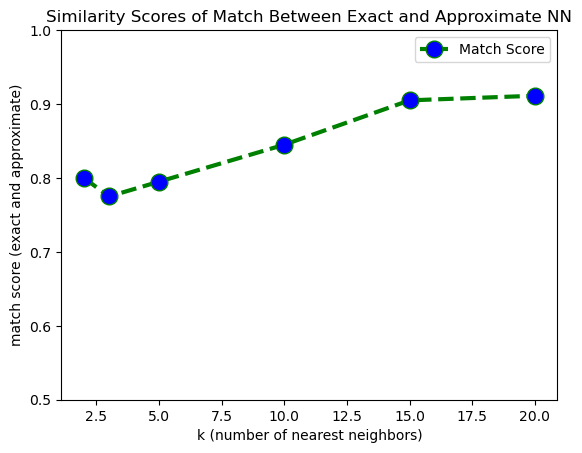

In [313]:
import matplotlib.pyplot as plt
  
# x axis values
x = [2,3,5,10,15,20]
# corresponding y axis values
y = [2,3,5,10,15,20]
  
# plotting the points 
plt.plot(x, k_LSH, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12, label= "Match Score")

# setting y axis range
plt.ylim(0.5, 1)
  
# naming the x axis
plt.xlabel('k (number of nearest neighbors)')
# naming the y axis
plt.ylabel('match score (exact and approximate)')
  
# giving a title to my graph
plt.title('Similarity Scores of Match Between Exact and Approximate NN')
  
plt.legend()
  
# function to show the plot
plt.show()

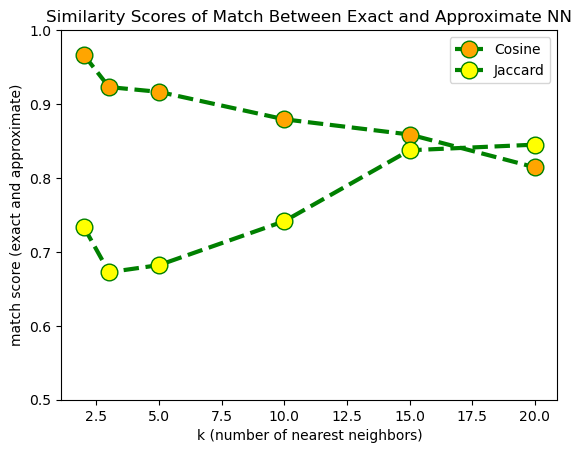

In [320]:
import matplotlib.pyplot as plt
  
# x axis values
x = [2,3,5,10,15,20]
# corresponding y axis values
y = [2,3,5,10,15,20]
  
# plotting the points 
plt.plot(x, c_LSH, label= 'Cosine', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='orange', markersize=12)
plt.plot(x, j_LSH, label= 'Jaccard', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=12)

# setting y axis range
plt.ylim(0.5,1)
  
# naming the x axis
plt.xlabel('k (number of nearest neighbors)')
# naming the y axis
plt.ylabel('match score (exact and approximate)')
  
# giving a title to my graph
plt.title('Similarity Scores of Match Between Exact and Approximate NN')
  
plt.legend()
# function to show the plot
plt.show()

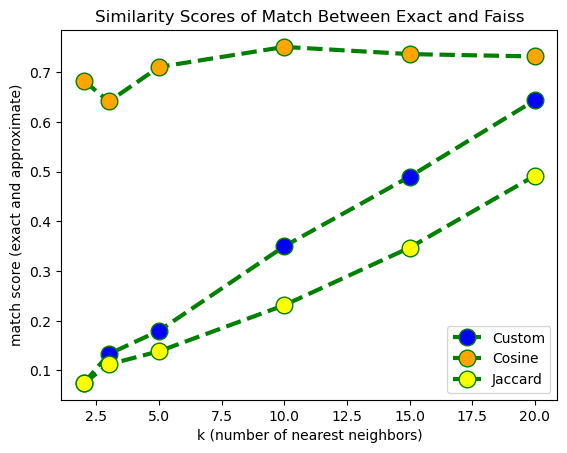

In [316]:
import matplotlib.pyplot as plt
  
# x axis values
x = [2,3,5,10,15,20]
# corresponding y axis values
y = [2,3,5,10,15,20]
  
# plotting the points 
plt.plot(x, k_faiss, label= "Custom", color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, c_faiss, label= 'Cosine', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='orange', markersize=12)
plt.plot(x, j_faiss, label= 'Jaccard', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=12)

# setting y axis range
#plt.ylim(0.5,1)
  
# naming the x axis
plt.xlabel('k (number of nearest neighbors)')
# naming the y axis
plt.ylabel('match score (exact and approximate)')
  
# giving a title to my graph
plt.title('Similarity Scores of Match Between Exact and Faiss')
  
plt.legend()
# function to show the plot
plt.show()

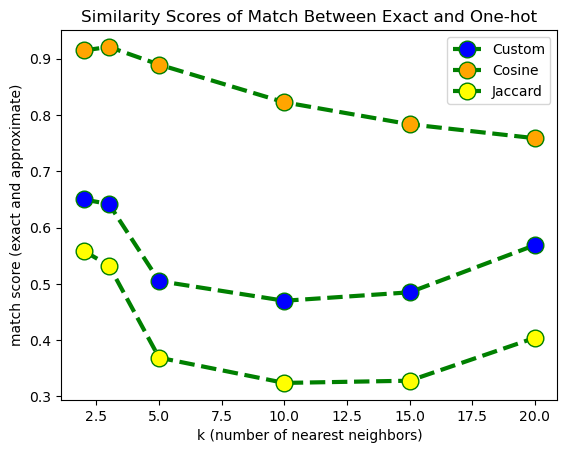

In [318]:
import matplotlib.pyplot as plt
  
# x axis values
x = [2,3,5,10,15,20]
# corresponding y axis values
y = [2,3,5,10,15,20]
  
# plotting the points 
plt.plot(x, k_one_hot, label= "Custom", color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, c_one_hot, label= 'Cosine', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='orange', markersize=12)
plt.plot(x, j_one_hot, label= 'Jaccard', color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='yellow', markersize=12)

# setting y axis range
#plt.ylim(0.5,1)
  
# naming the x axis
plt.xlabel('k (number of nearest neighbors)')
# naming the y axis
plt.ylabel('match score (exact and approximate)')
  
# giving a title to my graph
plt.title('Similarity Scores of Match Between Exact and One-hot')
  
plt.legend()
# function to show the plot
plt.show()